In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel as parallel
import torch.distributed as distributed
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ParameterGrid
import skorch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from torch.nn import BCELoss
import torch.nn.init as init
import random
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import shap
# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client
# from dask.distributed import Client, wait
# from dask_cuda import LocalCUDACluster
# from dask.utils import parse_bytes
# import cudf
# import dask_cudf
# from dask_ml.preprocessing import StandardScaler
# from dask_ml.impute import SimpleImputer
# from dask_ml.wrappers import ParallelPostFit
# from dask_ml.wrappers import Incremental
# from sklearn.svm import SVC
# import cuml
from torch.nn import init
import pickle
import dask
from dask import dataframe as dd
import dask.array as da
# import dask_ml.datasets
# import dask_ml.cluster
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [2]:
#Set seeds to allow for reproducibility of the results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
# cluster = LocalCUDACluster()
# client = Client(cluster)
# client

In [4]:
cer_data = pd.read_csv("intersect_4DNFIWCAQUIK.10kb.with_id.with_transcripts.erna_gene_filt.with_exp.txt", sep = "\t")

In [5]:
cer_data

,transcript1,expression1,transcript2,expression2,dist,norm_contacts
0,ENSG00000189339,-0.139152,ENSR00000249824,-0.218757,250000,1
1,ENSG00000008128,-0.007803,ENSR00000249824,-0.218757,220000,5
2,ENSR00000249824,-0.218757,ENSR00000249824,-0.218757,0,148
3,ENSG00000215915,0.020419,ENSR00000249824,-0.218757,480000,1
4,ENSG00000231050,-0.063613,ENSR00000249824,-0.218757,40000,1
...,...,...,...,...,...,...
95696,ENSG00000008735,-0.006373,ENSR00000147753,0.005671,50000,2
95697,ENSG00000100412,0.023097,ENSR00000147753,0.005671,9160000,1
95698,ENSR00000147753,0.005671,ENSG00000079974,-0.007761,110000,1
95699,ENSR00000143576,-0.130605,ENSG00000079974,-0.007761,32990000,1


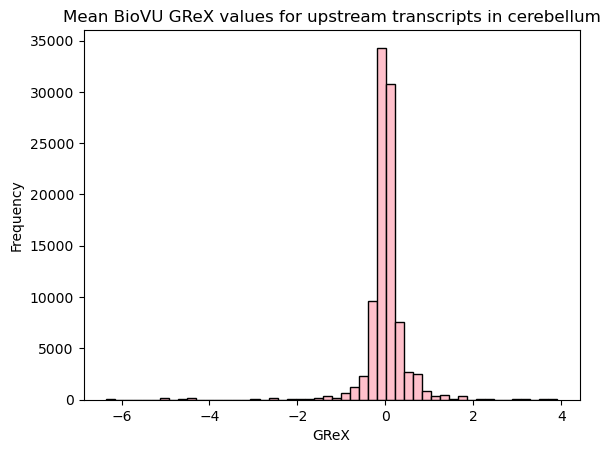

In [6]:
#Plot the distribution of the mean BioVU GReX values for transcript 1 in cerebellum
plt.hist(cer_data[['expression1']], bins=50, edgecolor='k', color ='pink')
plt.xlabel('GReX')
plt.ylabel('Frequency')
plt.title('Mean BioVU GReX values for upstream transcripts in cerebellum')
plt.savefig("cerebellum_grex_upstream_dist.png", dpi=300)

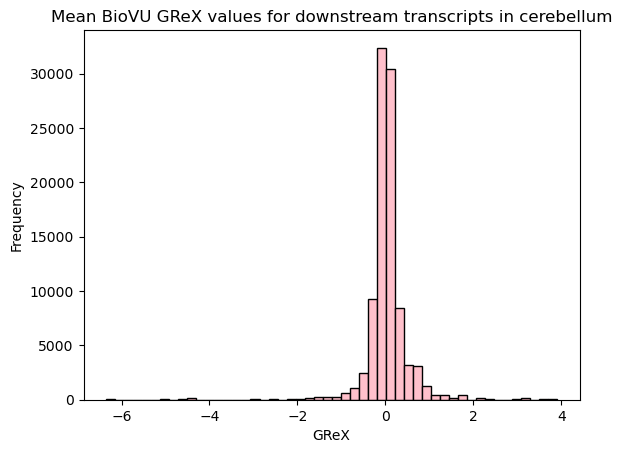

In [7]:
#Plot the distribution of the mean BioVU GReX values for transcript 2 in cerebellum
plt.hist(cer_data[['expression2']], bins=50, edgecolor='k', color='pink')
plt.xlabel('GReX')
plt.ylabel('Frequency')
plt.title('Mean BioVU GReX values for downstream transcripts in cerebellum')
plt.savefig("cerebellum_grex_downstream_dist.png", dpi=300)

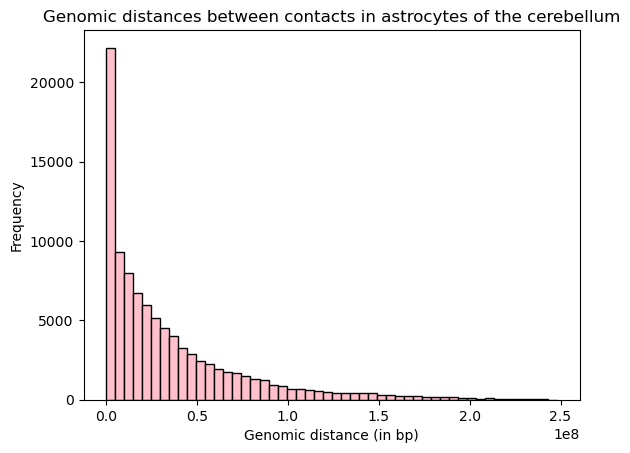

In [7]:
#Plot genomic distances in cerebellar astrocytes
plt.hist(cer_data[['dist']], bins=50, edgecolor='k', color='pink')
plt.xlabel('Genomic distance (in bp)')
plt.ylabel('Frequency')
plt.title('Genomic distances between contacts in astrocytes of the cerebellum')
plt.savefig("cerebellum_distance_contact_dist.png", dpi=300)

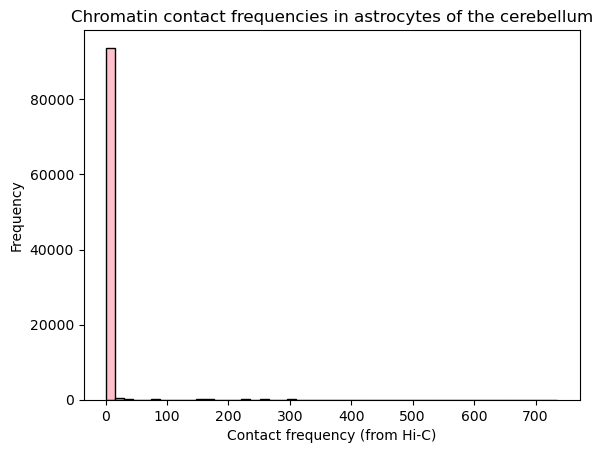

In [8]:
#Plot contact frequencies in cerebellar astrocytes
plt.hist(cer_data[['norm_contacts']], bins=50, edgecolor='k', color='pink')
plt.xlabel('Contact frequency (from Hi-C)')
plt.ylabel('Frequency')
plt.title('Chromatin contact frequencies in astrocytes of the cerebellum')
plt.savefig("cerebellum_contact_freq.png", dpi=300)

In [9]:
#Prepare training, validation, and test data
train = cer_data[["expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.4, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [10]:
train_set_final = np.array(train_set_final)
train_set_final = torch.tensor(train_set_final, dtype=torch.float32)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final = torch.tensor(train_labels_final, dtype=torch.float32)
train_labels_final.shape

torch.Size([57420])

In [11]:
val_set_final = np.array(val_set_final)
val_set_final = torch.tensor(val_set_final, dtype=torch.float32)
val_set_final.shape

val_labels_final = np.array(val_labels_final)
val_labels_final = torch.tensor(val_labels_final, dtype=torch.float32)
val_labels_final.shape

torch.Size([19140])

In [12]:
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([19141, 2])

In [13]:
train_features = np.array(train_features)
train_features = torch.tensor(train_features, dtype = torch.float32)

In [14]:
torch.cuda.is_available()

True

In [15]:
#Optimizng the number of neurons in each hidden layer - starting network has one hidden layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x

model = NeuralNetRegressor(  #Use NeuralNetRegressor for regression
    Net,
    criterion=nn.MSELoss,  #Use Mean Squared Error loss for regression
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__num_hidden_layers=1,
    module__output_size=1,  #Output size should be 1 for regression
    verbose=False,
    device="cuda:0",
)

#Define the grid of model parameters to search over
param_grid = {
    'module__hidden_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    #'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   #scoring="neg_mean_squared_error",
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.141312 using {'module__hidden_size': 90}
0.101054 (0.014064) with: {'module__hidden_size': 10}
0.104905 (0.011637) with: {'module__hidden_size': 20}
0.118670 (0.020521) with: {'module__hidden_size': 30}
0.113937 (0.019888) with: {'module__hidden_size': 40}
0.132973 (0.022334) with: {'module__hidden_size': 50}
0.134007 (0.024401) with: {'module__hidden_size': 60}
0.138907 (0.026588) with: {'module__hidden_size': 70}
0.138895 (0.023459) with: {'module__hidden_size': 80}
0.141312 (0.025692) with: {'module__hidden_size': 90}
0.140637 (0.025461) with: {'module__hidden_size': 100}


In [16]:
#Optimizng the number hidden layers - starting network has one hidden layer, so the actual number of hidden layers in grid search models is module__num_hidden_layers + 1
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=90,
    module__output_size=1,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   #scoring="neg_mean_squared_error",
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.195357 using {'module__num_hidden_layers': 2}
0.142801 (0.026387) with: {'module__num_hidden_layers': 1}
0.195357 (0.038395) with: {'module__num_hidden_layers': 2}
0.129010 (0.061664) with: {'module__num_hidden_layers': 3}
0.017491 (0.035111) with: {'module__num_hidden_layers': 4}
-0.000056 (0.000039) with: {'module__num_hidden_layers': 5}
-0.000053 (0.000043) with: {'module__num_hidden_layers': 6}
-0.000087 (0.000072) with: {'module__num_hidden_layers': 7}
-0.000071 (0.000053) with: {'module__num_hidden_layers': 8}
-0.000056 (0.000040) with: {'module__num_hidden_layers': 9}
-0.000076 (0.000057) with: {'module__num_hidden_layers': 10}


In [17]:
#Optimizng the batch size and number of epochs
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    module__input_size=input_shape,
    module__hidden_size=90,
    module__num_hidden_layers=2,
    module__output_size=1,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'batch_size':[10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 20, 30, 40, 50],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best: 0.223376 using {'batch_size': 80, 'max_epochs': 50}
0.141496 (0.048146) with: {'batch_size': 10, 'max_epochs': 10}
0.162111 (0.027602) with: {'batch_size': 10, 'max_epochs': 20}
0.176297 (0.025923) with: {'batch_size': 10, 'max_epochs': 30}
0.176659 (0.036795) with: {'batch_size': 10, 'max_epochs': 40}
0.193394 (0.059966) with: {'batch_size': 10, 'max_epochs': 50}
0.132311 (0.037209) with: {'batch_size': 20, 'max_epochs': 10}
0.157011 (0.029652) with: {'batch_size': 20, 'max_epochs': 20}
0.133659 (0.019338) with: {'batch_size': 20, 'max_epochs': 30}
0.163115 (0.041973) with: {'batch_size': 20, 'max_epochs': 40}
0.196516 (0.057110) with: {'batch_size': 20, 'max_epochs': 50}
0.161956 (0.035008) with: {'batch_size': 40, 'max_epochs': 10}
0.168945 (0.041196) with: {'batch_size': 40, 'max_epochs': 20}
0.154835 (0.023372) with: {'batch_size': 40, 'max_epochs': 30}
0.223035 (0.046351) with: {'batch_size': 40, 'max_epochs': 40

In [18]:
#Optimizng the training optimization algorithm
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=80,
    module__input_size=input_shape,
    module__hidden_size=90,
    module__num_hidden_layers=2,
    module__output_size=1,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'optimizer':[optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                  optim.Adam, optim.Adamax, optim.NAdam],
    'optimizer__lr': [0.0001, 0.0005 ,0.001, 0.002, 0.005, 0.006, 0.007, 0.008, 0.0085, 0.009, 0.01, 0.1, 0.2, 0.3]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 98 candidates, totalling 490 fits


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_regression.py", line 911, in r2_score
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_

Best: 0.325253 using {'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'optimizer__lr': 0.3}
0.157285 (0.020068) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0001}
0.135771 (0.034931) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0005}
0.151045 (0.036506) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
0.074143 (0.037695) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.002}
0.032199 (0.033014) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.005}
0.011365 (0.020728) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.006}
0.006303 (0.010657) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.007}
nan (nan) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.008}
0.001039 (0.002320) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0085}
-0.000127 (0.000101) with: {'optimizer': <class 'torch.o

In [19]:
#Optimizng how the weights are initialized
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adagrad,
    max_epochs=50,
    batch_size=80,
    module__input_size=input_shape,
    module__hidden_size=90,
    module__num_hidden_layers=2,
    module__output_size=1,
    optimizer__lr = 0.3,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'module__weight_init_hidden': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_],
    'module__weight_init_out': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",  #Use R2 score as the performance metric
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


Best: 0.315475 using {'module__weight_init_hidden': <function xavier_normal_ at 0x7f49dc9eeb90>, 'module__weight_init_out': <function xavier_uniform_ at 0x7f49dc9eeb00>}
0.199566 (0.059954) with: {'module__weight_init_hidden': <function uniform_ at 0x7f49dc9ee560>, 'module__weight_init_out': <function uniform_ at 0x7f49dc9ee560>}
0.167855 (0.037711) with: {'module__weight_init_hidden': <function uniform_ at 0x7f49dc9ee560>, 'module__weight_init_out': <function normal_ at 0x7f49dc9ee5f0>}
0.233703 (0.033729) with: {'module__weight_init_hidden': <function uniform_ at 0x7f49dc9ee560>, 'module__weight_init_out': <function zeros_ at 0x7f49dc9ee8c0>}
0.239813 (0.078390) with: {'module__weight_init_hidden': <function uniform_ at 0x7f49dc9ee560>, 'module__weight_init_out': <function xavier_normal_ at 0x7f49dc9eeb90>}
0.240368 (0.076919) with: {'module__weight_init_hidden': <function uniform_ at 0x7f49dc9ee560>, 'module__weight_init_out': <function xavier_uniform_ at 0x7f49dc9eeb00>}
0.209619 (

In [15]:
#Optimizng the activation function
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = self.activation(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adagrad,
    max_epochs=50,
    batch_size=80,
    module__input_size=input_shape,
    module__hidden_size=90,
    module__num_hidden_layers=2,
    module__output_size=1,
    optimizer__lr = 0.3,
    module__weight_init_hidden = init.xavier_normal_,
    module__weight_init_out = init.xavier_uniform_,
    verbose=False,
    device = "cuda:0",
    callbacks=[
        EpochScoring(scoring='r2', name='train_r2', on_train=True),
        EpochScoring(scoring='r2', name='valid_r2', on_train=False),
    ]
)

#Define the grid of model parameters to search over
param_grid = {
    'module__activation': [nn.Identity, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.ReLU6,
                          nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh,
                          nn.Sigmoid, nn.Hardsigmoid]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",  #Use R2 score as the performance metric
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best: 0.368018 using {'module__activation': <class 'torch.nn.modules.activation.Softsign'>}
-0.000145 (0.000231) with: {'module__activation': <class 'torch.nn.modules.linear.Identity'>}
0.299841 (0.043957) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>}
0.312969 (0.036517) with: {'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
0.172880 (0.012892) with: {'module__activation': <class 'torch.nn.modules.activation.ELU'>}
0.315763 (0.021133) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU6'>}
0.206703 (0.024121) with: {'module__activation': <class 'torch.nn.modules.activation.GELU'>}
0.117612 (0.030305) with: {'module__activation': <class 'torch.nn.modules.activation.Softplus'>}
0.368018 (0.034480) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>}
0.325811 (0.025601) with: {'module__activation': <class 'torch.nn.modules.activation.Tanh

In [22]:
# #Optimizng dropout
# n_cols = train_set_final.shape[1]
# input_shape = n_cols
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

# #Define the neural network model
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate1, dropout_rate2, weight_constraint):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate1)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.dropout2 = nn.Dropout(dropout_rate2)
#         self.fc3 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         self.weight_constraint = weight_constraint
#         #Manually init weights
#         weight_init_hidden(self.fc1.weight)
#         weight_init_hidden(self.fc2.weight)
#         weight_init_out(self.fc3.weight)

#     def forward(self, x):
#         #Maxnorm weight before actual forward pass
#         with torch.no_grad():
#            norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#            desired = torch.clamp(norm, max=self.weight_constraint)
#            self.fc1.weight *= (desired / norm)

#            norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#            desired = torch.clamp(norm, max=self.weight_constraint)
#            self.fc2.weight *= (desired / norm)

#         x = self.activation(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.activation(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.fc3(x)
#         return x
    
# model = NeuralNetRegressor(
#     Net,
#     criterion=nn.MSELoss,
#     optimizer=optim.Adagrad,
#     max_epochs=50,
#     batch_size=80,
#     module__input_size=input_shape,
#     module__hidden_size=90,
#     module__num_hidden_layers=2,
#     module__output_size=1,
#     optimizer__lr = 0.3,
#     module__weight_init_hidden = init.xavier_normal_,
#     module__weight_init_out = init.xavier_uniform_,
#     module__activation = nn.Softsign,
#     verbose=False,
#     device = "cuda:0",
#     callbacks=[
#         EpochScoring(scoring='r2', name='train_r2', on_train=True),
#         EpochScoring(scoring='r2', name='valid_r2', on_train=False),
#     ]
# )

# #Define the grid of model parameters to search over
# param_grid = {
#     'module__dropout_rate1': [0.0, 0.1, 0.3, 0.5],
#     'module__dropout_rate2': [0.0, 0.1, 0.3, 0.5],
#     'module__weight_constraint': [1.0, 3.0, 5.0, 7.0, 9.0]
# }

# #Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
# pds = PredefinedSplit(test_fold = split_index)

# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring="r2",  #Use R2 score as the performance metric
#                    n_jobs=1,
#                    verbose=1)

# #Fit with all data
# grid_result = clf.fit(X, y.float())

# #Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [24]:
# #Optimizng L1 and L2 regularization (without dropout)
# n_cols = train_set_final.shape[1]
# input_shape = n_cols
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

# #Define the neural network model
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, alpha_l1, alpha_l2):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.num_hidden_layers = num_hidden_layers - 1
#         self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         # manually init weights
#         weight_init_hidden(self.fc1.weight)
#         for i, hidden_layer in enumerate(self.hidden_layers):
#             weight_init_hidden(hidden_layer.weight)
#         weight_init_out(self.fc2.weight)

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         for i in range(self.num_hidden_layers):
#             x = self.activation(self.hidden_layers[i](x))
#         x = self.fc2(x)
#         return x

# #Add regularization to the optimizer
# from skorch.utils import to_device
# from skorch.callbacks import Callback
# from skorch.history import History

# class RegularizationCallback(Callback):
#     def __init__(self, alpha_l1=0.01, alpha_l2=0.01, seed_value=0):
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2
#         #self.seed_value = seed_value

#     def on_train_begin(self, net, X, y):
#         #torch.manual_seed(self.seed_value)
#         self.optimizer = net.optimizer_

#     def on_epoch_end(self, net, dataset_train, dataset_valid=None, **kwargs):
#         #Apply L1 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l1 * torch.sign(param.data)

#         #Apply L2 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l2 * param.data

#         #Update optimizer state with new parameter values
#         self.optimizer.state = net.optimizer_.state

#         #Add regularization loss to history
#         history = net.history
#         if 'reg_loss' not in history:
#             history.new_epoch()
#         history.record('reg_loss', self.alpha_l1 * sum([torch.norm(param, p=1) for param in net.module_.parameters() if param.requires_grad]) + 
#                               self.alpha_l2 * sum([torch.norm(param, p=2) for param in net.module_.parameters() if param.requires_grad]))
    
# model = NeuralNetRegressor(
#     Net,
#     criterion=nn.MSELoss,
#     optimizer=optim.Adagrad,
#     max_epochs=50,
#     batch_size=80,
#     module__input_size=input_shape,
#     module__hidden_size=90,
#     module__num_hidden_layers=2,
#     module__output_size=1,
#     optimizer__lr = 0.3,
#     module__weight_init_hidden = init.xavier_normal_,
#     module__weight_init_out = init.xavier_uniform_,
#     module__activation = nn.Softsign,
#     verbose=False,
#     device = "cuda:0",
#     callbacks=[
#         EpochScoring(scoring='r2', name='train_r2', on_train=True),
#         EpochScoring(scoring='r2', name='valid_r2', on_train=False),
#         RegularizationCallback(alpha_l1 = 0.01, alpha_l2 = 0.01)
#     ]
# )

# #Define the grid of model parameters to search over
# param_grid = {
#     'module__alpha_l1': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
#     'module__alpha_l2': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
# }

# #Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
# pds = PredefinedSplit(test_fold = split_index)

# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring="r2",  #Use R2 score as the performance metric
#                    n_jobs=1,
#                    verbose=1)

# #Fit with all data
# grid_result = clf.fit(X, y.float())

# #Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Text(0.5, 1.0, 'Training and Validation $\\mathregular{R^{2}}$')

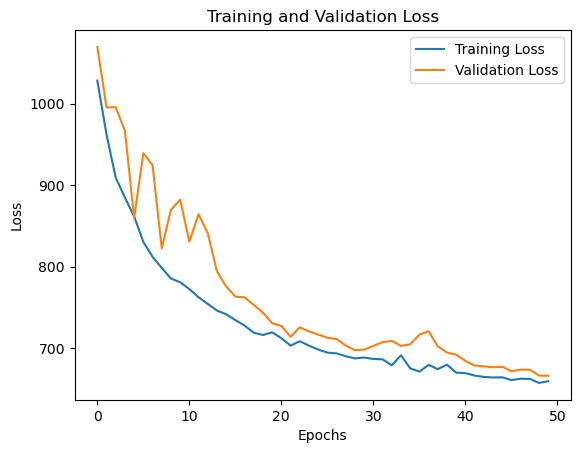

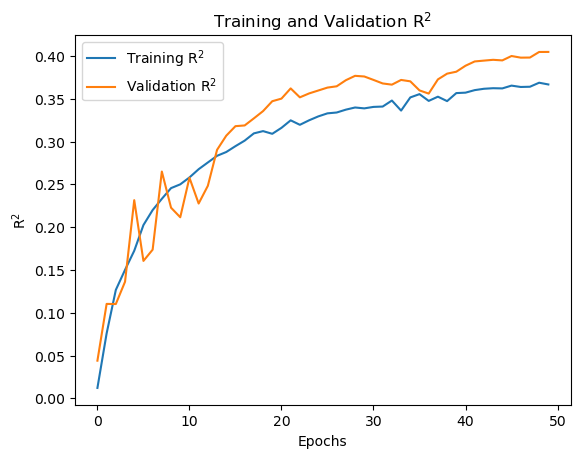

In [16]:
import matplotlib.pyplot as plt

#Get the best estimator
best_estimator = grid_result.best_estimator_
#print(best_estimator.history)

#Get training and validation loss and R2
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']
train_r2 = best_estimator.history[:, 'train_r2']
val_r2 = best_estimator.history[:, 'valid_r2']

#Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

#Plot the training and validation R2 curves
plt.figure()
plt.plot(train_r2, label=r'Training $\mathregular{R^{2}}$')
plt.plot(val_r2, label=r'Validation $\mathregular{R^{2}}$')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel(r'$\mathregular{R^{2}}$')
plt.title(r'Training and Validation $\mathregular{R^{2}}$')

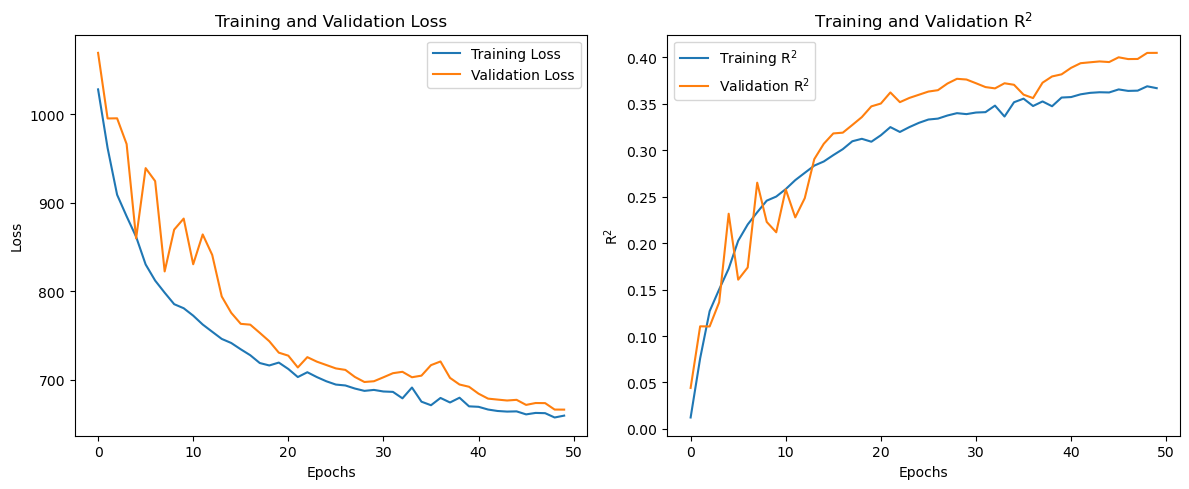

In [17]:
import matplotlib.pyplot as plt

#Get the best estimator
best_estimator = grid_result.best_estimator_

#Get training and validation loss and R2
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']
train_r2 = best_estimator.history[:, 'train_r2']
val_r2 = best_estimator.history[:, 'valid_r2']

#Create a figure
plt.figure(figsize=(12, 5))

#Subplot for the loss curves
plt.subplot(1, 2, 1)  #1 row, 2 columns, first plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

#Subplot for the AUC curves
plt.subplot(1, 2, 2)  #1 row, 2 columns, second plot
plt.plot(train_r2, label=r'Training $\mathregular{R^{2}}$')
plt.plot(val_r2, label=r'Validation $\mathregular{R^{2}}$')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel(r'$\mathregular{R^{2}}$')
plt.title(r'Training and Validation $\mathregular{R^{2}}$')

#Show the plots
plt.tight_layout()  #Adjusts space between plots for better layout
#plt.show()
plt.savefig("cerebellum_erna_gene_grex_vs_contact_freq_training_curves.png", dpi=300)

In [18]:
best_model = grid_result.best_estimator_.module_
#Save the best model to HDF5 format
torch.save(best_model.state_dict(), 'cerebellum_best_contact_regression_model.h5')

In [19]:
from sklearn.metrics import r2_score

#Evaluate performance on test set
y_pred = best_model(test_set_final.to("cuda:0"))

#Compute R-squared score
r2 = r2_score(test_labels_final, y_pred.detach().cpu().numpy())

print(r2)

0.37759778657811827


In [20]:
# #Surface plot
# gene1 = test_set_final.numpy()[:,0]
# gene2 = test_set_final.numpy()[:,1]
# gene1_grid, gene2_grid = np.meshgrid(gene1, gene2)

# #Convert to torch tensors
# input_data = torch.tensor(np.column_stack((gene1_grid.ravel(), gene2_grid.ravel())), dtype=torch.float32).to('cuda')

# #Get the model's predictions
# with torch.no_grad():
#     predictions_grid = best_model(input_data)
# predictions_grid = predictions_grid.cpu().numpy().reshape(gene1_grid.shape)

# #Plotting the 3D surface
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(gene1_grid, gene2_grid, predictions_grid, cmap='viridis')

# #Add labels and title
# ax.set_xlabel('Transcript 1 expression')
# ax.set_ylabel('Transcript 2 expression')
# ax.set_zlabel('Predicted contact frequency')
# ax.set_title('eRNA and gene expression versus predicted contact frequency')

# #Add a color bar which maps values to colors.
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# plt.show()

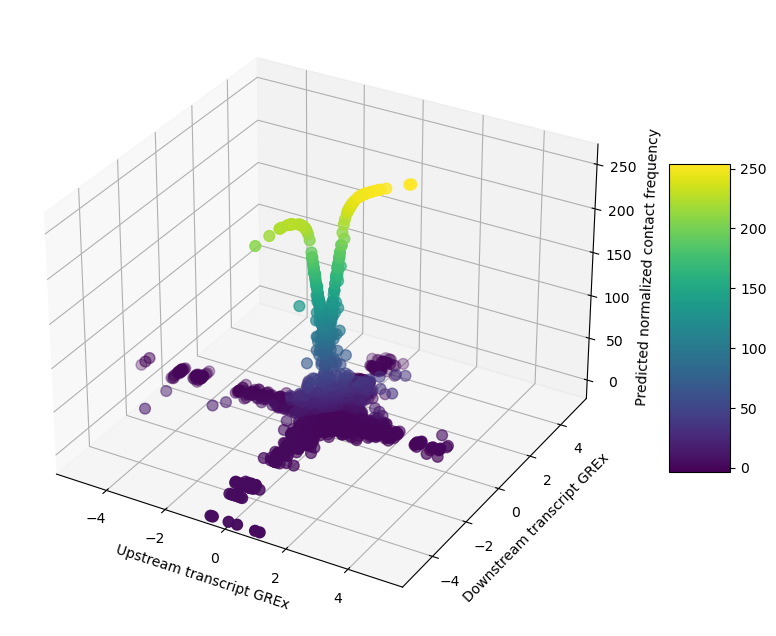

In [31]:
#Scatter plot
gene1 = test_set_final.numpy()[:,0]
gene2 = test_set_final.numpy()[:,1]
gene1_grid, gene2_grid = np.meshgrid(gene1, gene2)

#Convert to torch tensors
input_data = torch.tensor(np.column_stack((gene1_grid.ravel(), gene2_grid.ravel())), dtype=torch.float32).to('cuda:0')

#Get the model's predictions
with torch.no_grad():
    predictions = best_model(test_set_final.to('cuda:0')).cpu().numpy()

#Plotting the 3D scatter plot
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

#Using scatter for individual points
scatter = ax.scatter(gene1, gene2, predictions, c=predictions, cmap='viridis', s=60)  #s is the size of the points

#Add labels and title
ax.set_xlabel('Upstream transcript GREx')
ax.set_ylabel('Downstream transcript GREx')
ax.set_zlabel('Predicted normalized contact frequency')
#ax.set_title('eRNA and gene genetically regulated expression versus predicted contact frequency')
ax.set_xlim([-5.5, 5.5])
ax.set_ylim([-5.5, 5.5])

#Add a color bar which maps values to colors.
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

#plt.show()
plt.savefig("cerebellum_erna_gene_grex_vs_contact_freq.png", dpi=300)

In [33]:
#Sample training data for SHAP
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)

#Create a random sample of training data with which to use as a background sample for SHAP
import torch

#Define the fraction of data you want to sample (e.g., 0.1 for 10%)
sample_fraction = 0.2

#Compute the number of samples
num_samples = int(X.size(0) * sample_fraction)

#Randomly sample without replacement
sample_indices = torch.randperm(X.size(0))[:num_samples]
sample_data = X[sample_indices]

In [34]:
#Testing feature contribution using SHAP
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch
import shap

n_cols = train_set_final.shape[1]
input_shape = n_cols

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, input_size=2, hidden_size=90, output_size=1, num_hidden_layers=2, weight_init_hidden=init.xavier_normal_, weight_init_out=init.xavier_uniform_):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.activation = activation()
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.nn.functional.softsign(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.nn.functional.softsign(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = Net().to(device)
model.load_state_dict(torch.load('cerebellum_best_contact_regression_model.h5'))

explainer = shap.DeepExplainer(model, sample_data.to("cuda:0"))

#shap_values = explainer.shap_values(test_set_final)
#y_pred = model(test_set_final)
#auc = roc_auc_score(test_labels_final, y_pred.detach().cpu().numpy())

#print(auc)

In [35]:
shap_values = explainer.shap_values(test_set_final)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


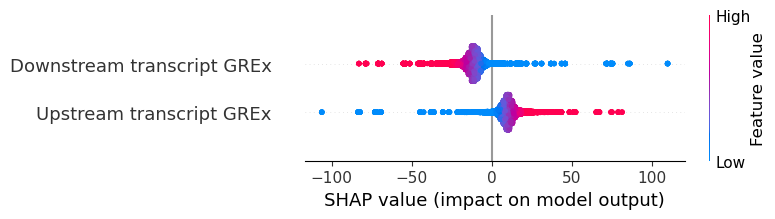

In [38]:
#feature_names = exp_file.iloc[:,1:].columns.values.tolist()
feature_names = ["Upstream transcript GREx", "Downstream transcript GREx"]

shap.summary_plot(shap_values, test_set_final, feature_names = feature_names)

In [41]:
#Save the figure at 300 dpi
feature_names = ["Upstream transcript GREx", "Downstream transcript GREx"]

shap.summary_plot(shap_values, test_set_final, feature_names=feature_names, plot_size=(10,4), show=False)

#Save the figure
#Save the plot
plt.savefig("cerebellum_shap_plot_erna_gene_grex_log_contacts.png", dpi=300, bbox_inches='tight')
plt.close()

In [42]:
global_shap_vals = np.abs(shap_values).mean(axis=0)
percent_contributions = global_shap_vals / np.sum(global_shap_vals)
percent_contributions

array([0.4694106, 0.5305894])

In [43]:
#Evaluate the proportion of enhancers and genes in the upstream and downstream transcript variables
train = cer_data[["transcript1", "transcript2", "expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
#train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.4, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [44]:
X = pd.concat([train_set_final, val_set_final], ignore_index=True)

In [45]:
#Compute number of gene-enhancer pairs in the training data
count_gene_enh = X[(X['transcript1'].str.startswith('ENSG')) & (X['transcript2'].str.startswith('ENSR'))].shape[0]
print(count_gene_enh)

37710


In [46]:
#Compute number of enhancer-gene pairs in the training data
count_enh_gene = X[(X['transcript1'].str.startswith('ENSR')) & (X['transcript2'].str.startswith('ENSG'))].shape[0]
print(count_enh_gene)

36117


In [47]:
#Compute number of enhancer-enhancer pairs in the training data
count_enh_enh = X[(X['transcript1'].str.startswith('ENSR')) & (X['transcript2'].str.startswith('ENSR'))].shape[0]
print(count_enh_enh)

2733


In [48]:
#Compute number of gene-gene pairs in the training data
count_gene_gene = X[(X['transcript1'].str.startswith('ENSG')) & (X['transcript2'].str.startswith('ENSG'))].shape[0]
print(count_gene_gene)

0


In [49]:
#Re-generate the entire set of training and test features
train_features = train.copy()
train_labels = train_features.pop("norm_contacts")
train_features.pop("dist")
train_features.pop("transcript1")
train_features.pop("transcript2")

train_features = torch.tensor(np.array(train_features), dtype = torch.float32)
train_labels = torch.tensor(np.array(train_labels), dtype = torch.float32)

In [50]:
test_set_final

,transcript1,transcript2,expression1,expression2
58872,ENSR00000240266,ENSG00000196990,-0.570908,0.145768
12709,ENSR00000290563,ENSG00000152672,-0.176785,-0.062596
46150,ENSG00000127948,ENSR00000326843,-0.024278,-0.129639
57845,ENSG00000236404,ENSR00000240994,0.100076,-0.088822
94014,ENSR00000301194,ENSG00000273342,0.375690,-0.027263
...,...,...,...,...
36259,ENSG00000251320,ENSR00000189129,0.008809,-1.721174
20613,ENSG00000163513,ENSR00000152623,0.138536,-1.559158
10241,ENSG00000081277,ENSR00000257717,-0.030737,0.236110
21641,ENSG00000272573,ENSR00000304912,-0.171789,0.662578


In [51]:
t1 = test_set_final.pop('transcript1').reset_index()
t2 = test_set_final.pop('transcript2').reset_index()
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([19141, 2])

In [52]:
#Predict outcomes using trained model
model_pred = model(test_set_final.to("cuda:0"))

In [53]:
model_pred

tensor([[3.2165],
        [3.2664],
        [1.6501],
        ...,
        [2.9803],
        [2.2801],
        [1.6360]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [54]:
test_set_final

tensor([[-0.5709,  0.1458],
        [-0.1768, -0.0626],
        [-0.0243, -0.1296],
        ...,
        [-0.0307,  0.2361],
        [-0.1718,  0.6626],
        [-0.0120,  0.3763]])

In [55]:
#Compare predictions with outcome
df1 = pd.DataFrame(test_labels_final, columns=['true_val'])
df2 = pd.DataFrame(model_pred.detach().cpu().numpy(), columns=['prediction'])
df3 = pd.DataFrame(t1, columns=['transcript1'])
df4 = pd.DataFrame(t2, columns=['transcript2'])

#Concatenate DataFrames side by side
result = pd.concat([df3, df4, df1, df2], axis=1)
result

result['residual'] = abs(result['prediction'] - result['true_val'])
result['frac_error'] = result['residual'] / result['true_val']

result_sorted = result.sort_values(by='frac_error')

#Save the resulting DataFrame to a CSV file
result_sorted.to_csv('cerebellum_contacts_exp_model_true_vs_pred.csv', index=False)

In [56]:
np.median(result_sorted['frac_error'])

0.8461658954620361

In [57]:
result_sorted

,transcript1,transcript2,true_val,prediction,residual,frac_error
10446,ENSG00000164253,ENSR00000186261,1,0.999820,0.000180,0.000180
1903,ENSR00000077521,ENSG00000140368,2,1.999623,0.000377,0.000188
6714,ENSR00000006646,ENSG00000152061,1,0.999628,0.000372,0.000372
6056,ENSG00000230461,ENSR00000021594,1,1.000533,0.000533,0.000533
8732,ENSR00000182881,ENSG00000145730,1,0.999460,0.000540,0.000540
...,...,...,...,...,...,...
3826,ENSG00000007341,ENSR00000015777,1,187.921982,186.921982,186.921982
10531,ENSR00000237929,ENSR00000337624,1,188.648132,187.648132,187.648132
17808,ENSG00000166435,ENSR00000047195,1,195.511719,194.511719,194.511719
3012,ENSR00000035870,ENSR00000035870,1,219.135315,218.135315,218.135315


In [58]:
wb_data = pd.read_csv("intersect_4DNFI18UHVRO.10kb.with_id.with_transcripts.erna_gene_filt.with_exp.txt", sep = "\t")

In [59]:
wb_data

,transcript1,expression1,transcript2,expression2,dist,norm_contacts
0,ENSG00000272455,-0.028341,ENSR00000000202,-0.000818,140000,48
1,ENSG00000224051,-0.012343,ENSR00000000202,-0.000818,230000,32
2,ENSG00000224870,0.005104,ENSR00000000202,-0.000818,150000,58
3,ENSG00000197785,0.055437,ENSR00000000202,-0.000818,40000,121
4,ENSG00000272512,-0.025277,ENSR00000000202,-0.000818,560000,12
...,...,...,...,...,...,...
85625,ENSR00000144311,-0.147444,ENSG00000008735,-0.045636,26700000,1
85626,ENSR00000146851,0.470797,ENSG00000008735,-0.045636,7710000,1
85627,ENSR00000144050,-0.134191,ENSG00000008735,-0.045636,28870000,1
85628,ENSR00000146851,0.470797,ENSG00000100299,-0.279448,7720000,3


In [60]:
#Prepare training, validation, and test data
wb_test = wb_data[["expression1", "expression2", "dist", "norm_contacts"]]
wb_test_features = wb_test.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#cer_test_features["norm_contacts"] = np.log(cer_test_features["norm_contacts"])

##Log1p-normalize genomic distances
#cer_test_features["dist"] = np.log1p(cer_test_features["dist"])

wb_test_labels = wb_test_features.pop("norm_contacts")
wb_test_features.pop("dist")
wb_test_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
wb_test_labels = np.array(wb_test_labels)

wb_test_labels

array([48, 32, 58, ...,  1,  3,  1])

In [61]:
wb_test_features = np.array(wb_test_features)
wb_test_features = torch.tensor(wb_test_features, dtype=torch.float32)
wb_test_features.shape

torch.Size([85630, 2])

In [62]:
from sklearn.metrics import r2_score

#Evaluate performance on test set
y_wb_pred = model(wb_test_features.to("cuda:0"))

#Compute R-squared score
r2 = r2_score(wb_test_labels, y_wb_pred.detach().cpu().numpy())

print(r2)

0.1782277797064008
